# Adversarial Validation

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)
sns.set_theme(context="notebook", style="whitegrid")

## Config

In [2]:
# file paths
DATA_DIR = Path("../input/alvin-smart-money-classification-challenge")

# data
TRAIN_DATA = DATA_DIR / "train.csv"

TEST_DATA = DATA_DIR / "test.csv"

EXTRA_DATA = DATA_DIR / "extra_data.csv"

# columns in the data
INDEX_COL = "Transaction_ID"

TARGET_COL = "MERCHANT_CATEGORIZED_AS"

# random state
RANDOM_STATE = 98765

## Loading the data

In [3]:
dt_cols = ["MERCHANT_CATEGORIZED_AT", "PURCHASED_AT"]
train_df = pd.read_csv(
    TRAIN_DATA, index_col=INDEX_COL, parse_dates=dt_cols
)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, ID_04mk78fa to ID_zztijwt3
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   MERCHANT_CATEGORIZED_AT                373 non-null    datetime64[ns, UTC]
 1   MERCHANT_NAME                          373 non-null    object             
 2   MERCHANT_CATEGORIZED_AS                373 non-null    object             
 3   PURCHASE_VALUE                         373 non-null    int64              
 4   PURCHASED_AT                           373 non-null    datetime64[ns, UTC]
 5   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  373 non-null    bool               
 6   USER_AGE                               61 non-null     float64            
 7   USER_GENDER                            367 non-null    object             
 8   USER_HOUSEHOLD                         373 non-null    int64              
 9

In [4]:
test_df = pd.read_csv(
    TEST_DATA, index_col=INDEX_COL, parse_dates=dt_cols
)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558 entries, ID_00x9h2yx to ID_zz7zds1s
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   MERCHANT_CATEGORIZED_AT                558 non-null    datetime64[ns, UTC]
 1   MERCHANT_NAME                          558 non-null    object             
 2   PURCHASE_VALUE                         558 non-null    int64              
 3   PURCHASED_AT                           558 non-null    datetime64[ns, UTC]
 4   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  558 non-null    bool               
 5   USER_AGE                               85 non-null     float64            
 6   USER_GENDER                            553 non-null    object             
 7   USER_HOUSEHOLD                         558 non-null    int64              
 8   USER_INCOME                            558 non-null    int64              
 9

In [5]:
extra_df = pd.read_csv(
    EXTRA_DATA, index_col=INDEX_COL, parse_dates=dt_cols
)
extra_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, ID_v13grrw3 to ID_cxhvhlnw
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   MERCHANT_CATEGORIZED_AT                0 non-null      datetime64[ns]     
 1   MERCHANT_NAME                          10000 non-null  object             
 2   MERCHANT_CATEGORIZED_AS                0 non-null      float64            
 3   PURCHASE_VALUE                         10000 non-null  int64              
 4   PURCHASED_AT                           10000 non-null  datetime64[ns, UTC]
 5   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  10000 non-null  bool               
 6   USER_AGE                               1158 non-null   float64            
 7   USER_GENDER                            9966 non-null   object             
 8   USER_HOUSEHOLD                         10000 non-null  int64              


## Feature engineering

In [6]:
# helper functions
from string import punctuation

def featurize_merch_name(series: pd.Series) -> pd.DataFrame:
    """Extract features from merchant names"""
    df = pd.DataFrame()
    # clean the merchant names
    df["merch_name"] = series.str.replace(f"[{punctuation}]", "").str\
        .replace("\d+", "", regex=True).str.replace(" \w ", " ", regex=True)
    
    # obtain a list of tokens for each cell
    merch_name_tokens = df["merch_name"].str.split()
    
    # count the number of tokens
    df["merch_name_count"] = merch_name_tokens.str.len()
    
    # extract the last token in each cell
    df["merch_last_name"] = merch_name_tokens.str[-1]
    
    # obtain a dataframe with 1 token per cell
    merch_name_df = df["merch_name"].str.split(expand=True).drop(
        [3,4,5], axis=1).add_prefix("merch_name_")
    return df.join(merch_name_df)


def featurize_ts(series: pd.Series, col_prefix: str) -> pd.DataFrame:
    """Extract features from a timestamp column"""
    df = pd.DataFrame()
    df[f"{col_prefix}_month"] = series.dt.month
    df[f"{col_prefix}_day"] = series.dt.day
    df[f"{col_prefix}_weekday"] = series.dt.weekday
    df[f"{col_prefix}_hour"] = series.dt.hour
    return df

def featurize(df: pd.DataFrame) -> pd.DataFrame:
    """Create new features"""
    merch_df = featurize_merch_name(df["MERCHANT_NAME"])
    purchase_df = featurize_ts(df["PURCHASED_AT"], "purchase")
    cat_df = featurize_ts(df["MERCHANT_CATEGORIZED_AT"], "cat")
    df = df.join(merch_df)
    df = df.join(purchase_df)
    df = df.join(cat_df)
    df["IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY"] = df[
        "IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY"].astype(int)
    df["log_purchase"] = df["PURCHASE_VALUE"].apply(np.log)
    df["log_income"] = df["USER_INCOME"].apply(np.log)
    df["household_per_capita_income"] = df["USER_INCOME"] / df["USER_HOUSEHOLD"]
    cols_to_drop = ["PURCHASED_AT", "MERCHANT_CATEGORIZED_AT", "USER_AGE"]
    return df.drop(cols_to_drop, axis=1)

In [7]:
train_feat_df = featurize(train_df)
test_feat_df = featurize(test_df)
extra_feat_df = featurize(extra_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


## Encoding categorical features

In [8]:
def encode_categorical(df):
    numeric_cols = [
        "PURCHASE_VALUE", "USER_INCOME", "log_purchase",
        "log_income", "household_per_capita_income"
    ]
    numeric_df = df[numeric_cols]
    categorical_df = df[df.columns.difference(numeric_cols)]

    # cast bool to int
    bool_cols = df.select_dtypes("bool")
    df[bool_cols.columns] = bool_cols.astype(int)

    # ordinal encode
    categorical_cols = df.select_dtypes(exclude=["int64", "float64"])
    for col in categorical_cols:
        df[col], _ = df[col].factorize()
    return df

## Train vs test

In [9]:
train_feat_df = train_feat_df.drop(TARGET_COL, axis=1)
TARGET_COL = "is_test"
train_feat_df[TARGET_COL] = 0
test_feat_df[TARGET_COL] = 1
df = pd.concat([train_feat_df, test_feat_df]).sample(frac=1)
df = encode_categorical(df)
df[TARGET_COL].value_counts()

1    558
0    373
Name: is_test, dtype: int64

In [10]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

y = df[TARGET_COL]
X = df.drop(TARGET_COL, axis=1)

lgb = LGBMClassifier()
cv_results = cross_val_score(lgb, X, y, scoring="roc_auc")
print(f"AUC scores: {cv_results}")
print("AUC mean:{}, std:{}".format(
    np.mean(cv_results), np.std(cv_results)))

AUC scores: [0.51720238 0.52551882 0.44184363 0.52540541 0.4757958 ]
AUC mean:0.4971532067782067, std:0.033226653823257735


## Train vs extra

In [11]:
train_feat_df = train_feat_df.drop(TARGET_COL, axis=1)
TARGET_COL = "is_extra"
train_feat_df[TARGET_COL] = 0
extra_feat_df[TARGET_COL] = 1
df = pd.concat([train_feat_df, extra_feat_df]).sample(frac=1)
df = encode_categorical(df)
df[TARGET_COL].value_counts()

1    10000
0      373
Name: is_extra, dtype: int64

In [12]:
y = df[TARGET_COL]
X = df.drop(TARGET_COL, axis=1)

lgb = LGBMClassifier()
cv_results = cross_val_score(lgb, X, y, scoring="roc_auc")
print(f"AUC scores: {cv_results}")
print("AUC mean:{}, std:{}".format(
    np.mean(cv_results), np.std(cv_results)))

AUC scores: [1. 1. 1. 1. 1.]
AUC mean:1.0, std:4.965068306494546e-17


In [13]:
lgb.fit(X, y)
fi = pd.Series(lgb.feature_importances_, lgb.feature_name_)

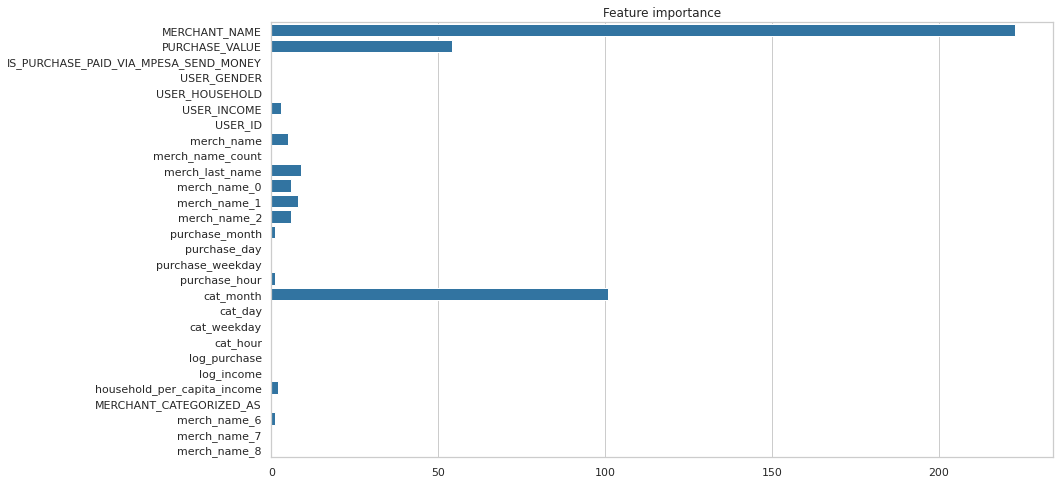

In [14]:
fig, ax = plt.subplots()

sns.barplot(x=fi.values, y=fi.index, ax=ax, color="tab:blue")
ax.set_title("Feature importance")
plt.show()